# Training Surrogates

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OJWatson/emidm/blob/main/examples/surrogate_notebook.ipynb)

In [1]:
!git clone https://github.com/OJWatson/emidm.git
%cd emidm
!pip install .

Cloning into 'emidm'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (402/402), done.
remote: Compressing objects: 100% (280/280), done.
remote: Total 402 (delta 122), reused 346 (delta 72), pack-reused 0 (from 0)
Receiving objects: 100% (402/402), 7.93 MiB | 15.70 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/emidm
Processing /content/emidm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for emidm: filename=emidm-0.1-py3-none-any.whl size=5483 sha256=378039ec4542021209d6b33267de35724784debf2e5e1949d99501d82f1ee5bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-3tumb3lt/wheels/00/20/c7/da80873e879ce001145dfae720e01a3365dcfa6526b8b5a366
Successfully built emidm


In [2]:
# Imports from our own package
from emidm.sir import run_sir, run_model_with_replicates, plot_model_outputs
from emidm.sampler import generate_lhs_samples
import pandas as pd
from plotnine import ggplot, aes, geom_line, facet_wrap

In [3]:
# Demonstrate running one model
single = run_sir()

# Show the output
single

,t,N,S,I,R
0,0,1000,990,10,0
1,1,1000,989,8,3
2,2,1000,989,8,3
3,3,1000,986,11,3
4,4,1000,984,13,3
...,...,...,...,...,...
96,96,1000,196,15,789
97,97,1000,195,15,790
98,98,1000,195,14,791
99,99,1000,195,12,793


<Axes: xlabel='t'>

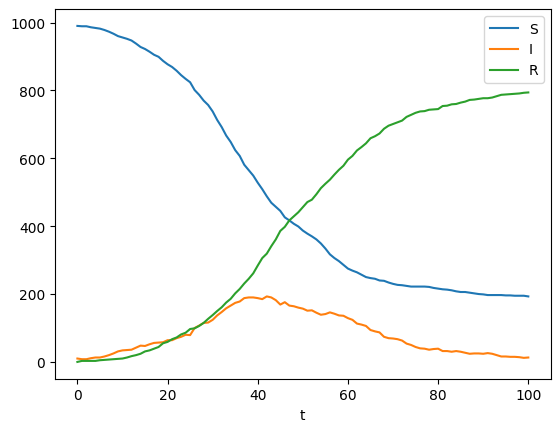

In [4]:
# Show a single plot line
single.plot("t", ["S", "I", "R"])


<Axes: xlabel='t'>

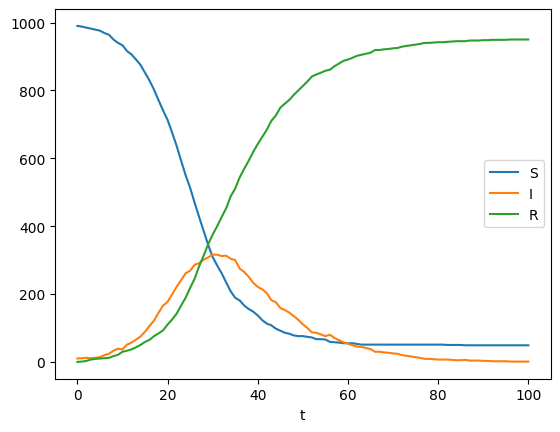

In [5]:
# We can also vary the parameters
alt = run_sir(beta = 0.3)
alt.plot("t", ["S", "I", "R"])

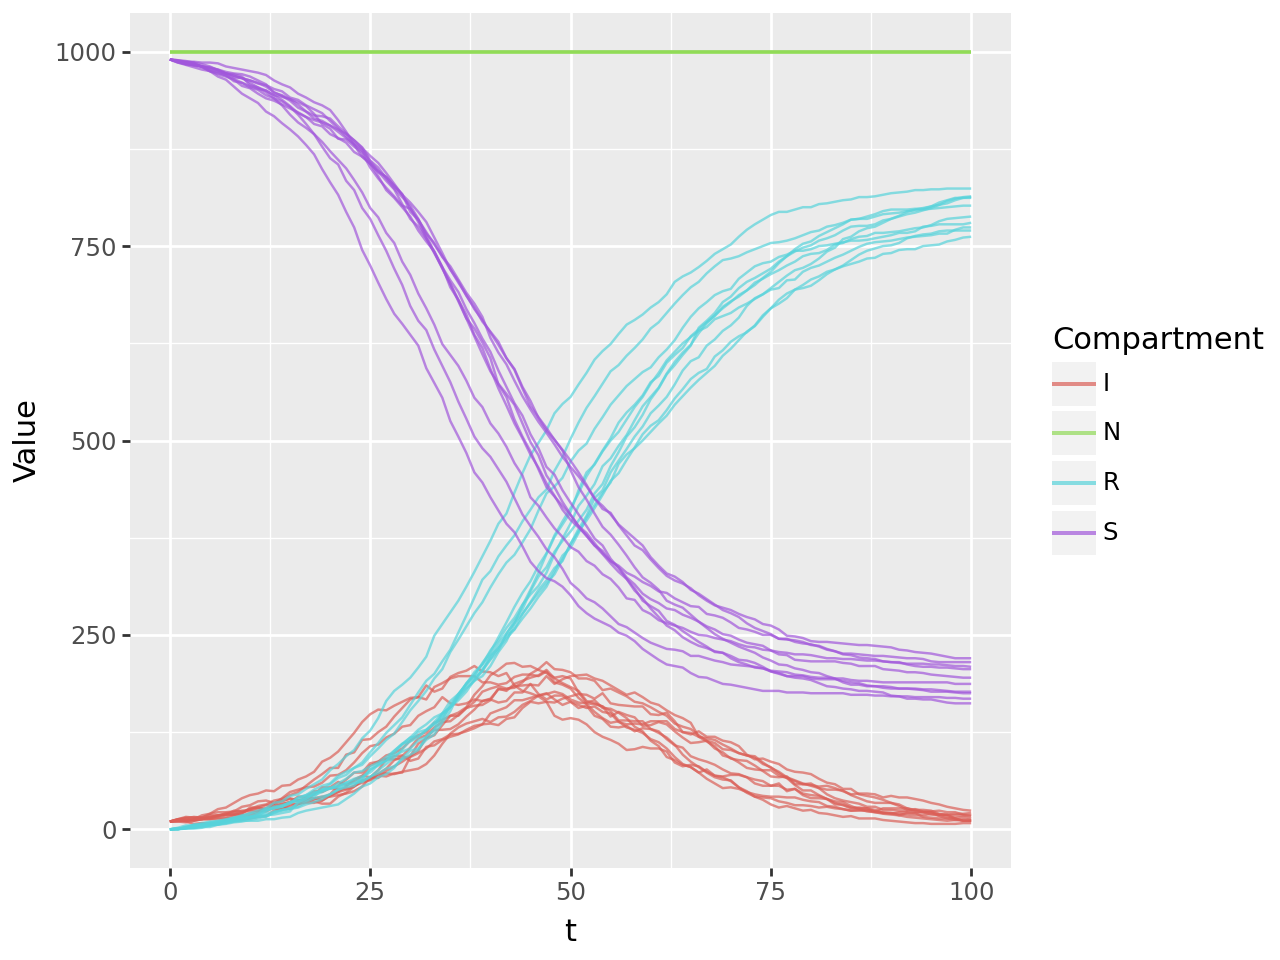

In [6]:
# we can run multiple realisations
reps = run_model_with_replicates(model = run_sir, reps = 10)

# and plot these
p = plot_model_outputs(reps)

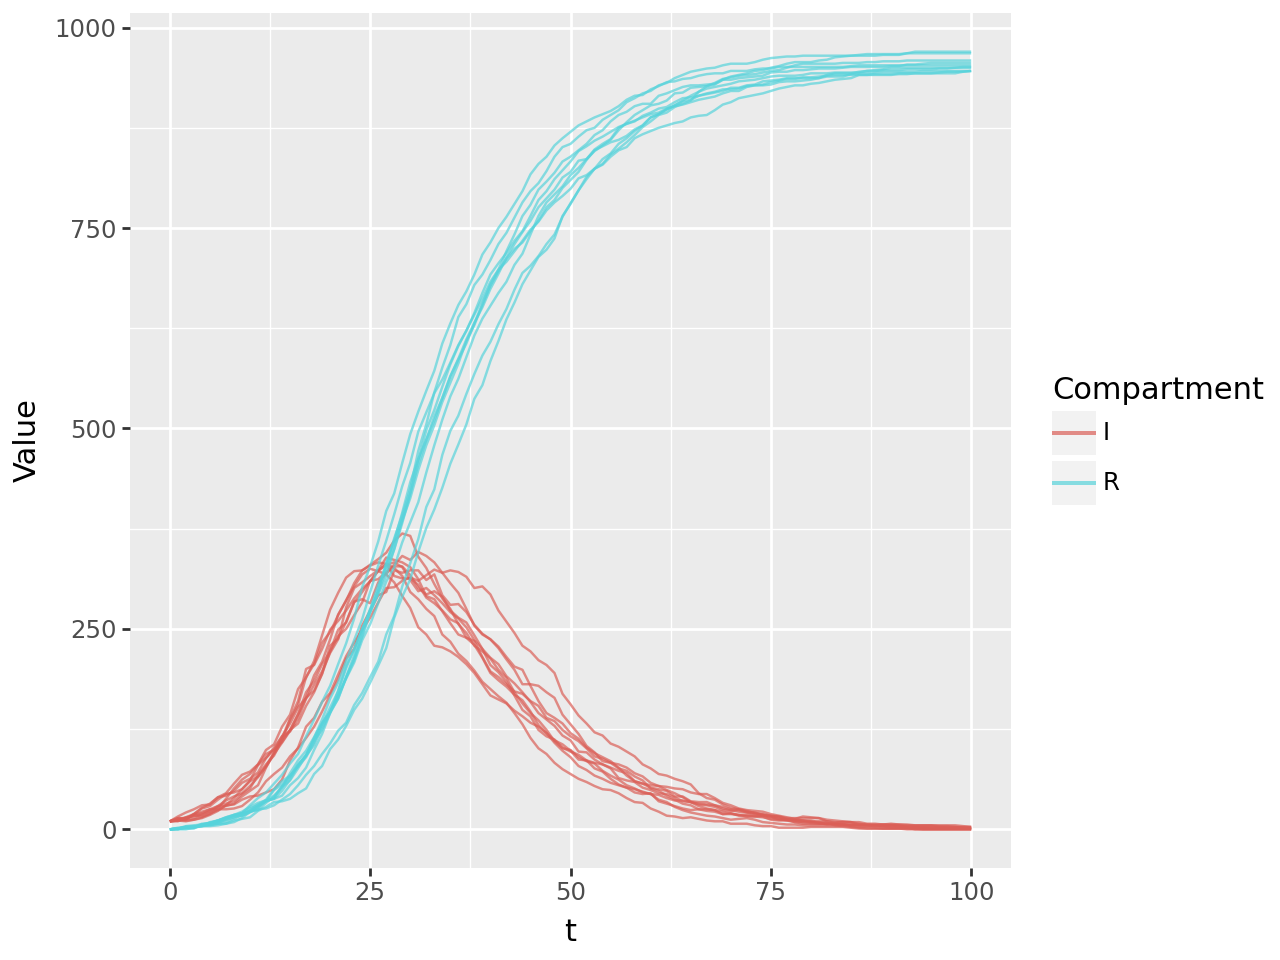

In [7]:
# we can also by args to run_sir through kwargs
reps = run_model_with_replicates(model=run_sir, reps=10, beta = 0.3)

# and plot these
p = plot_model_outputs(reps, columns = ["I", "R"])

In [8]:
# now to generate a lhs sample
param_ranges = {"beta": [0.1, 0.5], "gamma": [0.05, 0.5]}
df_samples = generate_lhs_samples(param_ranges, n_samples=9, seed=42)
df_samples

,beta,gamma
0,0.376713,0.228056
1,0.150729,0.165132
2,0.229148,0.351219
3,0.421727,0.310697
4,0.272084,0.127481
5,0.350187,0.253662
6,0.471384,0.458862
7,0.302515,0.088638
8,0.119796,0.446809


In [9]:
# Run the model for each row of samples:
results = [
    run_model_with_replicates(**row.to_dict(), reps=10).assign(**row.to_dict())
    for _, row in df_samples.iterrows()
]

# Combine results into one DataFrame:
df_all_results = pd.concat(results, axis=0)

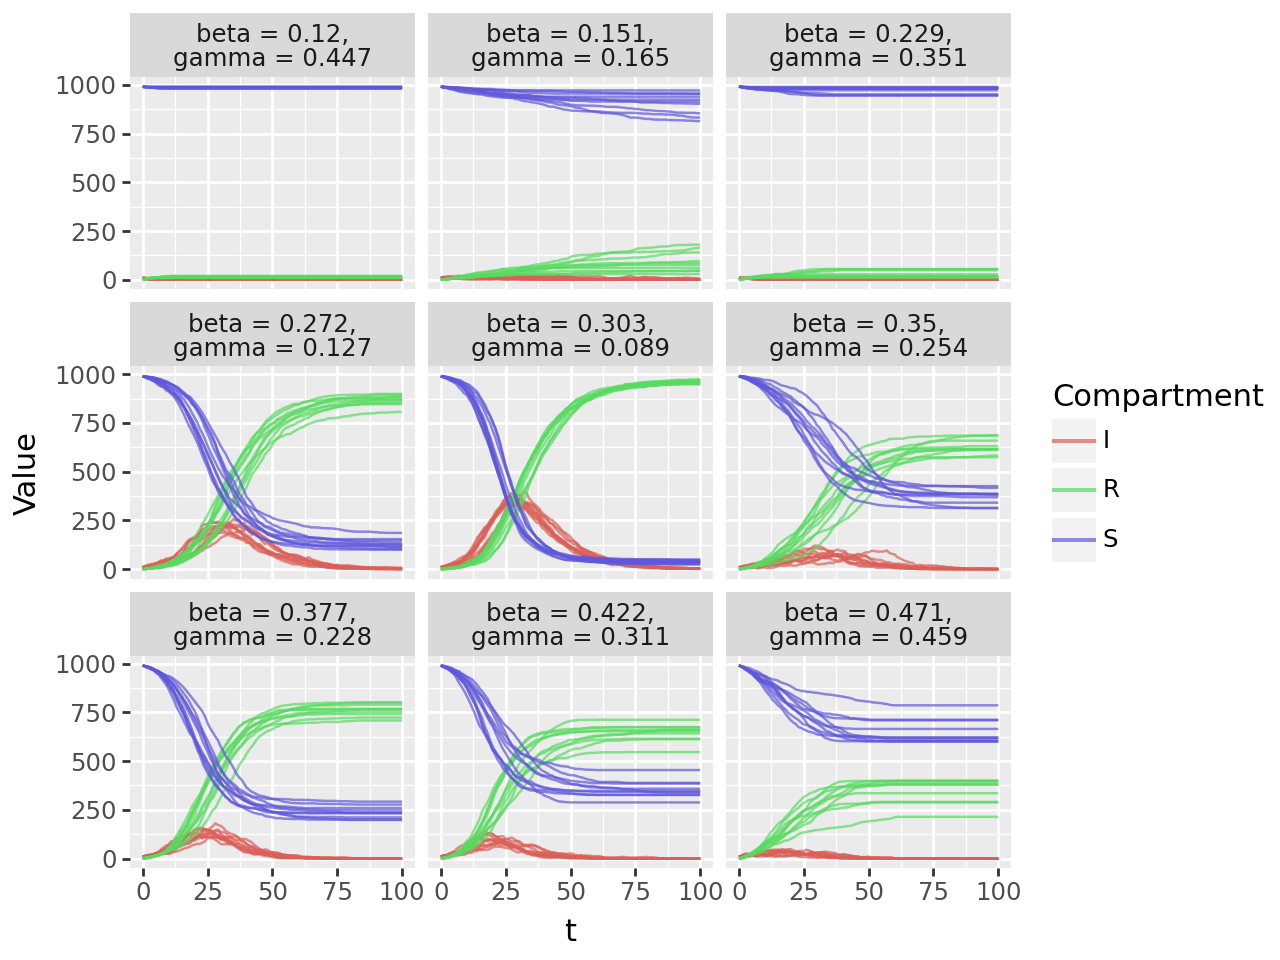

In [10]:
# Reshape dataframe into tidy long-format
df_long = df_all_results.melt(
    id_vars=["t", "replicate", "gamma", "beta"],
    value_vars=["S", "I", "R"],
    var_name="Compartment",
    value_name="Value",
)

# Add unique identifier for group plotting
df_long = df_long.assign(
    uid=df_long["Compartment"]
    + df_long["replicate"].astype(str)
)

# Add facet identifier for group plotting
df_long = df_long.assign(
    facet="beta = "
    + df_long["beta"].round(3).astype(str)
    + ",\n"
    + "gamma = "
    + df_long["gamma"].round(3).astype(str)
)

# Plot: color by compartment, lines grouped by replicate
p = (
    ggplot(
        df_long,
        aes(x="t", y="Value", group="uid", color="Compartment"),
    )
    + geom_line(alpha=0.7)
    + facet_wrap("facet")
)

# Explicitly plot
ggplot.show(p)

In [ ]:
# SIR Model Emulation with Neural Networks - Improved Version
# Imports from our own package
from emidm.sir import run_sir, run_model_with_replicates, plot_model_outputs
from emidm.sampler import generate_lhs_samples
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, Output
from IPython.display import display, clear_output

# 1. Data Preparation with Improved Sampling
# Generate samples ensuring beta > gamma (to create epidemics)
n_samples = 1000
np.random.seed(42)

# Create a custom sample generator that ensures beta > gamma
def generate_epidemic_samples(n_samples):
    samples = []

    # Set ranges
    beta_min, beta_max = 0.1, 0.5
    gamma_min, gamma_max = 0.05, 0.5

    for _ in range(n_samples):
        # Sample beta first
        beta = np.random.uniform(beta_min, beta_max)

        # Sample gamma ensuring it's less than beta
        # Set upper bound as min(beta, gamma_max) to ensure gamma < beta
        gamma_upper = min(beta, gamma_max)
        gamma = np.random.uniform(gamma_min, gamma_upper)

        samples.append({"beta": beta, "gamma": gamma})

    return pd.DataFrame(samples)

# Generate samples
df_samples = generate_epidemic_samples(n_samples)

# Print distribution to verify
print("Sample parameter statistics:")
print(df_samples.describe())

# Check R0 values (R0 = beta/gamma, should be >1 for epidemics)
df_samples['R0'] = df_samples['beta'] / df_samples['gamma']
print("\nR0 statistics:")
print(df_samples['R0'].describe())

# Run models with the parameters
results = []
for _, row in df_samples.iterrows():
    # Run model with current parameters
    model_run = run_sir(**row.to_dict())
    # Add parameters to the results
    model_run = model_run.assign(**row.to_dict())
    results.append(model_run)

# Combine all results
all_data = pd.concat(results, axis=0)

# Define window size for sequence prediction
window_size = 10

# 2. Improved Normalization Approach
# We'll normalize S and I by dividing by N to ensure values are between 0 and 1
N = 1000  # Total population size

# Create sequences with parameters and normalized S and I values
def create_normalized_sequences_with_params(data, window_size=10, N=1000):
    X_seq = []
    X_params = []
    y = []
    groups = data.groupby(['beta', 'gamma'])

    for (beta, gamma), group in groups:
        # Sort by time
        group = group.sort_values('t')

        # Normalize S and I values by dividing by N
        s_values = group['S'].values / N
        i_values = group['I'].values / N

        # Create sequences
        for i in range(len(group) - window_size):
            # Add normalized S and I values
            seq = np.column_stack((s_values[i:i+window_size], i_values[i:i+window_size]))
            X_seq.append(seq)
            # Add beta and gamma parameters
            X_params.append(np.array([beta, gamma]))
            # Add target (next normalized S and I values)
            y.append(np.array([s_values[i+window_size], i_values[i+window_size]]))

    return np.array(X_seq), np.array(X_params), np.array(y)

# Create normalized sequences with parameters
X_seq, X_params, y = create_normalized_sequences_with_params(all_data, window_size, N)

# Split into train, validation, and test sets (70%, 15%, 15%)
X_seq_train, X_seq_temp, X_params_train, X_params_temp, y_train, y_temp = train_test_split(
    X_seq, X_params, y, test_size=0.3, random_state=42)

X_seq_val, X_seq_test, X_params_val, X_params_test, y_val, y_test = train_test_split(
    X_seq_temp, X_params_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_seq_train_tensor = torch.FloatTensor(X_seq_train)
X_params_train_tensor = torch.FloatTensor(X_params_train)
y_train_tensor = torch.FloatTensor(y_train)

X_seq_val_tensor = torch.FloatTensor(X_seq_val)
X_params_val_tensor = torch.FloatTensor(X_params_val)
y_val_tensor = torch.FloatTensor(y_val)

X_seq_test_tensor = torch.FloatTensor(X_seq_test)
X_params_test_tensor = torch.FloatTensor(X_params_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create custom Dataset class for our data
class SIRDataset(torch.utils.data.Dataset):
    def __init__(self, X_seq, X_params, y):
        self.X_seq = X_seq
        self.X_params = X_params
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_seq[idx], self.X_params[idx], self.y[idx]

# Create datasets
train_dataset = SIRDataset(X_seq_train_tensor, X_params_train_tensor, y_train_tensor)
val_dataset = SIRDataset(X_seq_val_tensor, X_params_val_tensor, y_val_tensor)
test_dataset = SIRDataset(X_seq_test_tensor, X_params_test_tensor, y_test_tensor)

# Create dataloaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# 3. Define Neural Network Models with Sigmoid Output Activation
# This ensures predictions are between 0 and 1
class FFNN(nn.Module):
    def __init__(self, seq_input_size, param_input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(seq_input_size + param_input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.sigmoid = nn.Sigmoid()  # Add sigmoid to constrain output between 0 and 1

    def forward(self, x_seq, x_params):
        x_seq = self.flatten(x_seq)
        x = torch.cat((x_seq, x_params), dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)  # Ensure outputs are between 0 and 1
        return x

class GRUModel(nn.Module):
    def __init__(self, seq_input_size, param_input_size, hidden_size, output_size, num_layers=2):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(seq_input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + param_input_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Add sigmoid to constrain output between 0 and 1

    def forward(self, x_seq, x_params):
        h0 = torch.zeros(self.num_layers, x_seq.size(0), self.hidden_size).to(x_seq.device)
        out, _ = self.gru(x_seq, h0)
        # Concatenate GRU output with parameters
        out = torch.cat((out[:, -1, :], x_params), dim=1)
        out = self.fc(out)
        out = self.sigmoid(out)  # Ensure outputs are between 0 and 1
        return out

class LSTMModel(nn.Module):
    def __init__(self, seq_input_size, param_input_size, hidden_size, output_size, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(seq_input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + param_input_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Add sigmoid to constrain output between 0 and 1

    def forward(self, x_seq, x_params):
        h0 = torch.zeros(self.num_layers, x_seq.size(0), self.hidden_size).to(x_seq.device)
        c0 = torch.zeros(self.num_layers, x_seq.size(0), self.hidden_size).to(x_seq.device)
        out, _ = self.lstm(x_seq, (h0, c0))
        # Concatenate LSTM output with parameters
        out = torch.cat((out[:, -1, :], x_params), dim=1)
        out = self.fc(out)
        out = self.sigmoid(out)  # Ensure outputs are between 0 and 1
        return out

# Initialize models
seq_input_size = 2  # S and I values per timestep
seq_length = window_size
param_input_size = 2  # beta and gamma parameters
hidden_size = 128  # Increased for better modeling capacity
output_size = 2  # Next S and I values

ffnn = FFNN(seq_input_size * seq_length, param_input_size, hidden_size, output_size)
gru = GRUModel(seq_input_size, param_input_size, hidden_size, output_size)
lstm = LSTMModel(seq_input_size, param_input_size, hidden_size, output_size)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move models to device
ffnn.to(device)
gru.to(device)
lstm.to(device)

# 4. Training function with Early Stopping
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, model_name, patience=20):
    train_losses = []
    val_losses = []

    # Initialize early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for seq, params, targets in train_loader:
            seq, params, targets = seq.to(device), params.to(device), targets.to(device)

            # Forward pass
            outputs = model(seq, params)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seq, params, targets in val_loader:
                seq, params, targets = seq.to(device), params.to(device), targets.to(device)
                outputs = model(seq, params)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                # Restore the best model weights
                model.load_state_dict(best_model_state)
                break

    return train_losses, val_losses

# 5. Loss function: MSE
criterion = nn.MSELoss()

# 6. Optimizers with learning rate and weight decay (regularization)
learning_rate = 0.001
weight_decay = 1e-5  # L2 regularization to prevent overfitting
num_epochs = 200     # Increased epochs with early stopping for better convergence

ffnn_optimizer = optim.Adam(ffnn.parameters(), lr=learning_rate, weight_decay=weight_decay)
gru_optimizer = optim.Adam(gru.parameters(), lr=learning_rate, weight_decay=weight_decay)
lstm_optimizer = optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=weight_decay)

# 7. Train models
print("Training FFNN...")
ffnn_train_losses, ffnn_val_losses = train_model(
    ffnn, train_loader, val_loader, ffnn_optimizer, criterion, num_epochs, "FFNN")

print("Training GRU...")
gru_train_losses, gru_val_losses = train_model(
    gru, train_loader, val_loader, gru_optimizer, criterion, num_epochs, "GRU")

print("Training LSTM...")
lstm_train_losses, lstm_val_losses = train_model(
    lstm, train_loader, val_loader, lstm_optimizer, criterion, num_epochs, "LSTM")

# 8. Plotting loss curves
plt.figure(figsize=(12, 8))

# FFNN
plt.subplot(3, 1, 1)
plt.plot(ffnn_train_losses, label='Training Loss')
plt.plot(ffnn_val_losses, label='Validation Loss')
plt.title('FFNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# GRU
plt.subplot(3, 1, 2)
plt.plot(gru_train_losses, label='Training Loss')
plt.plot(gru_val_losses, label='Validation Loss')
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# LSTM
plt.subplot(3, 1, 3)
plt.plot(lstm_train_losses, label='Training Loss')
plt.plot(lstm_val_losses, label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Sample parameter statistics:
              beta        gamma
count  1000.000000  1000.000000
mean      0.295575     0.174983
std       0.119455     0.097898
min       0.101976     0.050951
25%       0.187150     0.099593
50%       0.298708     0.148048
75%       0.400272     0.235213
max       0.499765     0.483694

R0 statistics:
count    1000.000000
mean        2.023418
std         1.175983
min         1.000249
25%         1.243309
50%         1.623678
75%         2.359319
max         8.331151
Name: R0, dtype: float64
Training samples: 63700
Validation samples: 13650
Test samples: 13650
Using device: cuda
Training FFNN...
FFNN - Epoch [10/200], Train Loss: 0.0001, Val Loss: 0.0001
FFNN - Epoch [20/200], Train Loss: 0.0001, Val Loss: 0.0001
FFNN - Epoch [30/200], Train Loss: 0.0001, Val Loss: 0.0001
FFNN - Epoch [40/200], Train Loss: 0.0001, Val Loss: 0.0001
FFNN - Epoch [50/200], Train Loss: 0.0001, Val Loss: 0.0001
FFNN - Epoch [60/200], Train Loss: 0.0001, Val Loss: 0.0001
FFNN - E

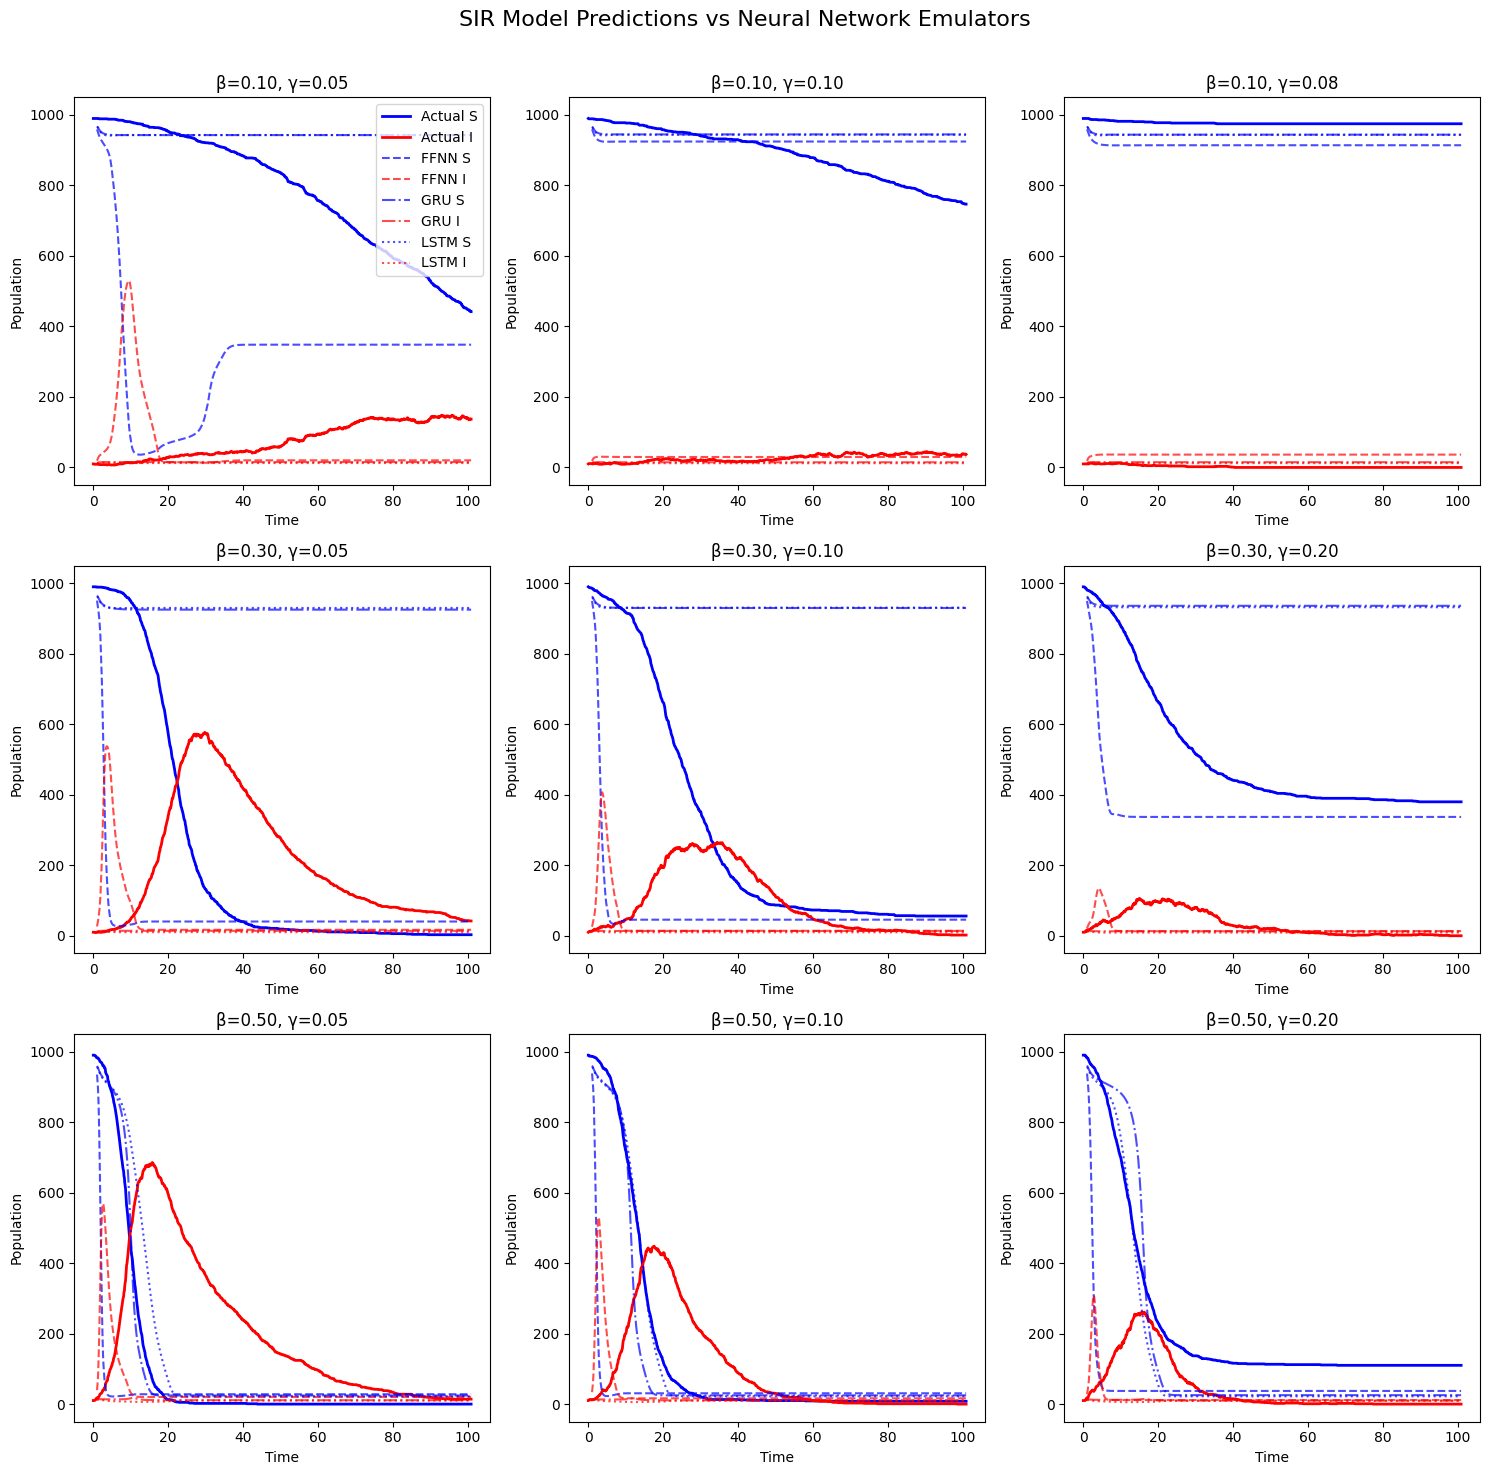

In [14]:
# 9. Function to predict timeseries with normalized outputs
def predict_timeseries(model, initial_sequence, beta, gamma, n_steps, N=1000):
    """
    Use the trained model to predict n_steps ahead, including beta and gamma parameters

    Args:
        model: Trained PyTorch model
        initial_sequence: Initial sequence of normalized shape (window_size, 2) with S and I values (0-1)
        beta: Beta parameter value
        gamma: Gamma parameter value
        n_steps: Number of steps to predict
        N: Population size for denormalization

    Returns:
        Array of predicted values (denormalized S and I)
    """
    model.eval()

    # Initialize with the provided sequence (should already be normalized)
    current_sequence = initial_sequence.copy()
    predictions = []

    # Prepare beta and gamma parameters
    params = torch.FloatTensor([[beta, gamma]]).to(device)

    with torch.no_grad():
        for _ in range(n_steps):
            # Convert current sequence to tensor
            seq_tensor = torch.FloatTensor(current_sequence.reshape(1, window_size, 2)).to(device)

            # Get prediction (normalized values between 0-1)
            y_pred = model(seq_tensor, params)
            y_pred_np = y_pred.cpu().numpy()[0]  # Extract predictions

            # Add to predictions list
            predictions.append(y_pred_np)

            # Update sequence by removing oldest timestep and adding prediction
            current_sequence = np.roll(current_sequence, -1, axis=0)
            current_sequence[-1] = y_pred_np

    # Convert predictions to numpy array and denormalize
    predictions = np.array(predictions)
    denormalized_predictions = predictions * N

    return denormalized_predictions

# Collect all models in a dictionary
models = {
    'FFNN': ffnn,
    'GRU': gru,
    'LSTM': lstm
}

# 10. Create validation visualization grid (3x3)
# Define beta and gamma values for the grid, ensuring beta > gamma
beta_values = [0.1, 0.3, 0.5]
gamma_values = [0.05, 0.1, 0.2]  # Adjusted to ensure epidemics (beta > gamma)

# Create figure for the 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('SIR Model Predictions vs Neural Network Emulators', fontsize=16)

# Loop through all combinations of beta and gamma
for i, beta in enumerate(beta_values):
    for j, gamma in enumerate(gamma_values):
        # Ensure gamma <= beta for epidemics
        if gamma > beta:
            gamma = beta * 0.8  # Set gamma to 80% of beta if it's larger

        # Get the specific subplot
        ax = axes[i][j]

        # Run the SIR model with these parameters
        result_df = run_sir(beta=beta, gamma=gamma, T=100, dt=0.1)

        # Get time points and actual values
        time_points = result_df['t'].values
        actual_S = result_df['S'].values
        actual_I = result_df['I'].values

        # Plot actual SIR model values
        ax.plot(time_points, actual_S, 'b-', linewidth=2, label='Actual S')
        ax.plot(time_points, actual_I, 'r-', linewidth=2, label='Actual I')

        # Create initial sequence for prediction (normalized)
        initial_seq = np.column_stack((actual_S[:window_size] / N, actual_I[:window_size] / N))
        n_predict = len(time_points) - window_size

        # Make predictions with each model, explicitly passing beta and gamma
        for model_name, model in models.items():
            # Generate predictions
            predictions = predict_timeseries(model, initial_seq, beta, gamma, n_predict, N)

            # Set line style based on model
            if model_name == 'FFNN':
                linestyle = '--'
            elif model_name == 'GRU':
                linestyle = '-.'
            else:  # LSTM
                linestyle = ':'

            # Plot predicted values
            ax.plot(time_points[window_size:], predictions[:, 0], 'b'+linestyle,
                    alpha=0.7, linewidth=1.5, label=f'{model_name} S')
            ax.plot(time_points[window_size:], predictions[:, 1], 'r'+linestyle,
                    alpha=0.7, linewidth=1.5, label=f'{model_name} I')

        # Set title, labels and axis limits
        ax.set_title(f'β={beta:.2f}, γ={gamma:.2f}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        ax.set_ylim(-50, N + 50)

        # Only add legend to the first plot to avoid clutter TODO fix this maybe
        if i == 0 and j == 0:
            ax.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for suptitle (i.e add spacing)
plt.show()